In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

In [4]:
os.getcwd()

'E:\\Au_notes\\Deep learning\\Codes\\A2\\COMP4329_A2\\CNNs'

In [5]:
# there some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/train.csv'
output_file = '../dataset/train_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 3:
            img_id, labels = row[0], row[1]
            caption_parts = row[2:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, labels, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/train_fixed.csv


In [6]:
# there some ", and \n" inside some examples so we need to handle that when reading csv
import csv

input_file = '../dataset/test.csv'
output_file = '../dataset/test_fixed.csv'

with open(input_file, 'r', encoding='utf-8', newline='') as infile, \
     open(output_file, 'w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.reader(infile)
    # this line means if face some special charater mentioned above, it will quote them as a whole part
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)
    
    headers = next(reader)
    writer.writerow(headers)

    for row in reader:
        if len(row) >= 2:
            img_id = row[0]
            caption_parts = row[1:]

            caption_parts = [part.replace('\n', '').replace('\r', '').strip()
                             for part in caption_parts if part.strip() != '']

            caption = ', '.join(caption_parts).rstrip(',')

            writer.writerow([img_id, caption])
        else:
            print(f"still have some issues inside rows (test)：{row}")
            
print(f"finished! new document file path:{output_file}")

finished! new document file path:../dataset/test_fixed.csv


In [7]:
train_df = pd.read_csv('../dataset/train_fixed.csv')
test_df = pd.read_csv('../dataset/test_fixed.csv')

In [8]:
train_df.head(5)

,ImageID,Labels,Caption,Unnamed: 3
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,NaN
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,NaN
2,2.jpg,1,They are brave for riding in the jungle on tho...,NaN
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,NaN
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,NaN


In [9]:
df1 = pd.read_csv('../dataset/train.csv')

In [10]:
train_df.iloc[1014][2]

C:\Users\13714\AppData\Local\Temp\ipykernel_28428\1310959229.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_df.iloc[1014][2]


'Atop an oriental rug rests a dog and two low-lying tables and a taller onefull of very tidily arranged piles of jeans and tops.'

In [17]:
train_df.drop(columns=['Unnamed: 3'], inplace=True)
train_df.to_csv('../dataset/train_fixed.csv', index=False, encoding='utf-8')

In [12]:
train_df.head(5)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [29]:
from PIL import ImageOps

def pad_to_320(image, fill_color=(0,0,0)):
    w, h = image.size
    pad_w = 320 - w
    pad_h = 320 - h
    padding = (pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2)
    return ImageOps.expand(image, padding, fill=fill_color)

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image, ImageOps
import os
from torchvision.transforms import Compose, ToTensor

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, processed_img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.processed_img_dir = processed_img_dir
        self.transform = transform
        self.num_classes = 19
        
        # 创建目标文件夹
        os.makedirs(processed_img_dir, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def pad_to_320(self, image, fill_color=(0,0,0)):
        w, h = image.size
        pad_w = 320 - w
        pad_h = 320 - h
        padding = (pad_w//2, pad_h//2, pad_w - pad_w//2, pad_h - pad_h//2)
        return ImageOps.expand(image, padding, fill=fill_color)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['ImageID']
        img_path = os.path.join(self.img_dir, img_id)
        
        # 加载原始图片
        image = Image.open(img_path).convert('RGB')
        
        # padding到320x320
        image_processed = self.pad_to_320(image)
        
        # 保存处理后的图片到processed_img_dir，名称与原图完全一致
        save_path = os.path.join(self.processed_img_dir, img_id)
        image_processed.save(save_path)

        if self.transform:
            image_processed = self.transform(image_processed)

        # 标签处理
        label_vec = torch.zeros(self.num_classes, dtype=torch.float32)
        labels_str = str(row['Labels']).split()
        for label in labels_str:
            label_idx = int(label) - 1
            label_vec[label_idx] = 1.0

        return image_processed, label_vec, img_id  # 返回img_id方便验证对应关系


In [35]:
# 文件夹定义
processed_img_dir = '../dataset/processed_images'
original_img_dir = '../dataset/images'
csv_file = '../dataset/train_fixed.csv'

transform = Compose([ToTensor()])

# 实例化dataset（图片将自动保存）
dataset = CustomDataset(csv_file=csv_file,
                        img_dir=original_img_dir,
                        processed_img_dir=processed_img_dir,
                        transform=transform)

# 使用DataLoader遍历保存所有图片
loader = DataLoader(dataset, batch_size=32, shuffle=False)

for idx, (images, labels, img_ids) in enumerate(loader):
    print(f"Batch {idx+1} 已处理完毕，共处理图片: {(idx+1)*32}")

print("所有图片处理完毕并保存到:", processed_img_dir)

Batch 1 已处理完毕，共处理图片: 32
Batch 2 已处理完毕，共处理图片: 64
Batch 3 已处理完毕，共处理图片: 96
Batch 4 已处理完毕，共处理图片: 128
Batch 5 已处理完毕，共处理图片: 160
Batch 6 已处理完毕，共处理图片: 192
Batch 7 已处理完毕，共处理图片: 224
Batch 8 已处理完毕，共处理图片: 256
Batch 9 已处理完毕，共处理图片: 288
Batch 10 已处理完毕，共处理图片: 320
Batch 11 已处理完毕，共处理图片: 352
Batch 12 已处理完毕，共处理图片: 384
Batch 13 已处理完毕，共处理图片: 416
Batch 14 已处理完毕，共处理图片: 448
Batch 15 已处理完毕，共处理图片: 480
Batch 16 已处理完毕，共处理图片: 512
Batch 17 已处理完毕，共处理图片: 544
Batch 18 已处理完毕，共处理图片: 576
Batch 19 已处理完毕，共处理图片: 608
Batch 20 已处理完毕，共处理图片: 640
Batch 21 已处理完毕，共处理图片: 672
Batch 22 已处理完毕，共处理图片: 704
Batch 23 已处理完毕，共处理图片: 736
Batch 24 已处理完毕，共处理图片: 768
Batch 25 已处理完毕，共处理图片: 800
Batch 26 已处理完毕，共处理图片: 832
Batch 27 已处理完毕，共处理图片: 864
Batch 28 已处理完毕，共处理图片: 896
Batch 29 已处理完毕，共处理图片: 928
Batch 30 已处理完毕，共处理图片: 960
Batch 31 已处理完毕，共处理图片: 992
Batch 32 已处理完毕，共处理图片: 1024
Batch 33 已处理完毕，共处理图片: 1056
Batch 34 已处理完毕，共处理图片: 1088
Batch 35 已处理完毕，共处理图片: 1120
Batch 36 已处理完毕，共处理图片: 1152
Batch 37 已处理完毕，共处理图片: 1184
Batch 38 已处理完毕，共处理图片: 1216
Batch 39 已处理完毕，共处

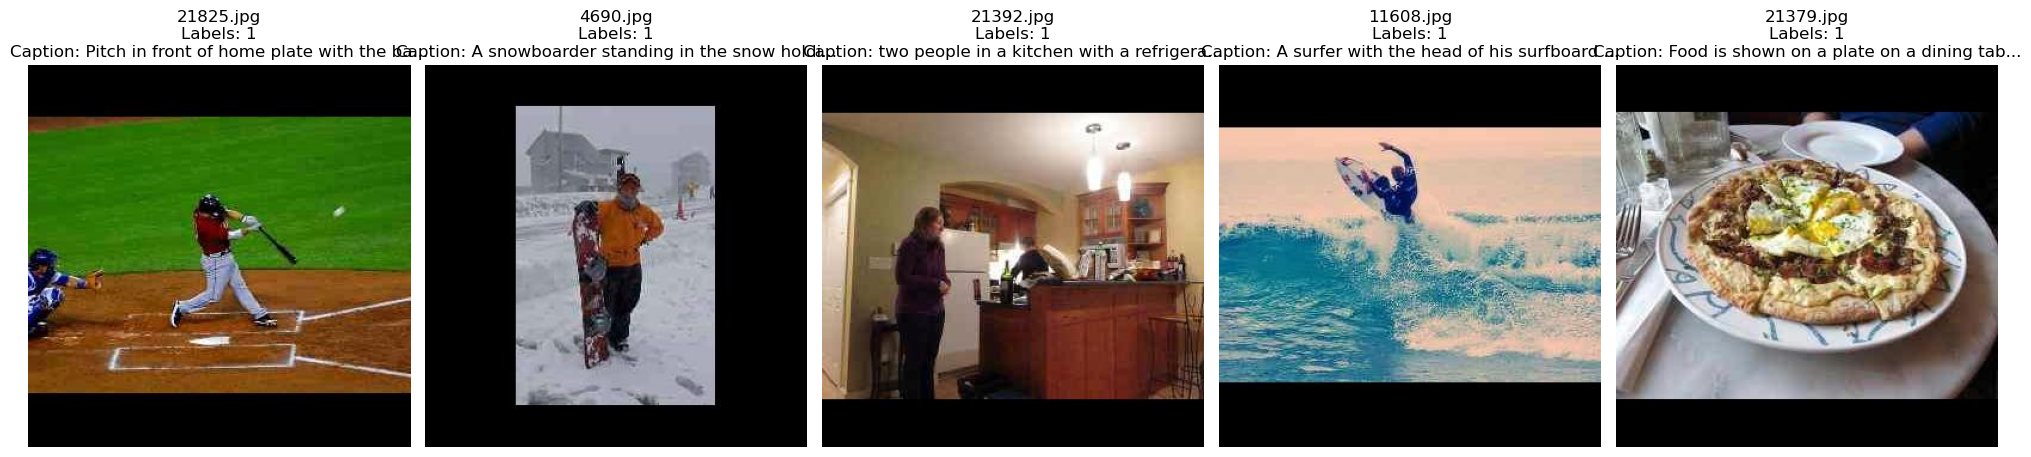

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# 明确路径
csv_file = '../dataset/train_fixed.csv'
processed_img_dir = '../dataset/processed_images'

# 加载csv文件
df = pd.read_csv(csv_file)

# 随机抽取若干图片进行验证
samples = random.sample(range(len(df)), 5)

plt.figure(figsize=(20,5))

for idx, sample_idx in enumerate(samples):
    row = df.iloc[sample_idx]
    img_id = row['ImageID']
    labels = row['Labels']
    caption = row['Caption']
    
    img_path = os.path.join(processed_img_dir, img_id)
    image = Image.open(img_path)

    plt.subplot(1, 5, idx+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{img_id}\nLabels: {labels}\nCaption: {caption[:40]}...")

plt.tight_layout()
plt.show()

In [6]:
for idx, sample_idx in enumerate(samples):
    print(idx)
    print(sample_idx)

0
21825
1
4690
2
21392
3
11608
4
21379


In [7]:
df.head(5)

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
